# Deep Neural Net

Creating a variable-layer neural network from memory as a learning exercise.

Uses the cat v non-cat dataset from the [coursera course](https://www.coursera.org/specializations/deep-learning) on Deep Learning by Andrew Ng.

## Import Libraries

In [1]:
# import libraries
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons, make_classification


# load data
train_data = h5py.File('C:/Users/leahy/Google Drive/Freelance/own_projects/ml_from_scratch/datasets/train_catvnoncat.h5', 'r')
test_data = h5py.File('C:/Users/leahy/Google Drive/Freelance/own_projects/ml_from_scratch/datasets/test_catvnoncat.h5', 'r')
X_train = np.array(train_data['train_set_x'])
y_train = np.array(train_data['train_set_y'])
X_test = np.array(test_data['test_set_x'])
y_test = np.array(test_data['test_set_y'])

# X_train and X_test contain samples of [m, 64, 64, 3], representing image
# hight x width x RGB channels. Reshape to be single vector of size
# n * m. Also rescale by 255
X_train = X_train.reshape(X_train.shape[0], -1).T / 255
X_test = X_test.reshape(X_test.shape[0], -1).T / 255

# reshape the y's
y_train = y_train.reshape(1, len(y_train))
y_test = y_test.reshape(1, len(y_test))

## Set up Functions

In [10]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A


def initialise_params(layer_dims):
    init_params = dict()
    L = len(layer_dims)
    for i in range(1, L):
        cur_n = layer_dims[i]
        # set W initial weights to be the square root of nodes in prev. layer
        init_params["W" + str(i)] = np.random.randn(
            layer_dims[i], layer_dims[i - 1]) / np.sqrt(layer_dims[i - 1])
        init_params["b" + str(i)] = np.zeros([layer_dims[i], 1])
    
        assert(init_params['W' + str(i)].shape == (
            layer_dims[i], layer_dims[i - 1]))
        assert(init_params['b' + str(i)].shape == (layer_dims[i], 1))
    return init_params


def forward_prop(X, params):
    L = len(params) // 2
    m = X.shape [1]
    preds = {}
    preds['A0'] = X
    A_prev = X
    # For layers 1:L-1 we use relu
    for i in range(1, L):
        W = params['W' + str(i)]
        b = params['b' + str(i)]
        Z = np.dot(W, A_prev) + b
        A = np.maximum(0, Z)
        
        preds['Z' + str(i)] = Z
        preds['A' + str(i)] = A

        assert(preds['Z' + str(i)].shape == (layer_dims[i], m))
        assert(preds['A' + str(i)].shape == (layer_dims[i], m))
        
        A_prev = A

    # For final layer use sigmoid
    W = params['W' + str(L)]
    b = params['b' + str(L)]
    Z = np.dot(W, A_prev) + b
    A = sigmoid(Z)
    
    preds['Z' + str(L)] = Z
    preds['A' + str(L)] = A
    
    assert(preds['Z' + str(L)].shape == (layer_dims[L], m))
    assert(preds['A' + str(L)].shape == (layer_dims[L], m))
    
    return preds


def compute_cost(AL, y):
    m = y.shape[1]
    cost = -np.sum(
        np.multiply(y, np.log(AL)) + np.multiply((1 - y), np.log(1- AL))) / m

    assert cost.shape == ()
    
    return cost


def back_prop(y, preds, params):
    L = len(params) // 2
    grads = {}
    m = y.shape[1]

    for i in reversed(range(1, L + 1)):
        if i == L:
            # for final case, dLdZL = dLdAL*dALdZL = AL - y
            AL = preds['A' + str(L)]
            dZ = AL - y
            grads['dZ' + str(L)] = dZ
        else:
            # these represent values at i + 1
            dZ_plus = grads['dZ' + str(i + 1)]
            W_plus = params['W' + str(i + 1)]
            Z = preds['Z' + str(i)]
            # gradient of relu fn
            relu_grad = np.zeros(Z.shape)
            relu_grad[Z > 0] = 1
            dZ = np.dot(W_plus.T, dZ_plus) * relu_grad
            grads['dZ' + str(i)] = dZ
            
        A_prev = preds['A' + str(i - 1)]
        grads['dW' + str(i)] = np.dot(dZ, A_prev.T) / m
        grads['db' + str(i)] = np.sum(dZ, axis=1, keepdims=True) / m
        
    return grads


def update_params(grads, params, alpha):
    L = len(params) // 2
    for i in range(1, L + 1):
        params['W' + str(i)] -= (alpha * grads['dW' + str(i)])
        params['b' + str(i)] -= (alpha * grads['db' + str(i)])
        
    return params


def fit(X, y, layer_dims, num_iterations, alpha):
    params = initialise_params(layer_dims)
    L = len(params) // 2
    for i in range(num_iterations):
        preds = forward_prop(X, params)
        J = compute_cost(preds['A' + str(L)], y)
        if i % 200 == 0:
            print(f'cost after iter {i}: {J}')
        grads = back_prop(y, preds, params)
        params = update_params(grads, params, alpha)
    return params

def predict(X, params):
    L = len(params) // 2
    preds = forward_prop(X, params)
    y_pred = preds['A' + str(L)]
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    return y_pred


def accuracy_score(y_test, y_pred):
    m = y_test.shape[1]
    score = np.sum(y_test == y_pred) / m
    print(f'accuracy: {score}')
    return score
        

## Fit, Predict, Score

In [11]:
layer_dims = [X_train.shape[0], 20, 7, 5, y_train.shape[0]]

# params = initialise_params(layer_dims)
params = fit(X_train, y_train, layer_dims, 2500, .0075)
y_pred_train = predict(X_train, params)
y_pred_test = predict(X_test, params)

accuracy_score(y_test, y_pred_test)

cost after iter 0: 0.7126132015464299
cost after iter 200: 0.5171138722809682
cost after iter 400: 0.3723447128870244
cost after iter 600: 0.26953657186668856
cost after iter 800: 0.08082897671418797
cost after iter 1000: 0.030670703898062503
cost after iter 1200: 0.016500565434296684
cost after iter 1400: 0.010434043911794274
cost after iter 1600: 0.007305974024531241
cost after iter 1800: 0.005462649489650543
cost after iter 2000: 0.004290822854963263
cost after iter 2200: 0.0034920385029479804
cost after iter 2400: 0.0029154881360515562
accuracy: 0.74


0.74

## Performance on generated dataset

In [52]:
m = 2000
# data = make_classification(n_features=2, n_redundant=0, n_informative=2,
#                            n_clusters_per_class=2, n_samples=m)
# data = make_circles(n_samples=m, factor=.5, noise=.03)

data = make_moons(n_samples=m, noise=.05)


X, y = data[0].T, data[1].reshape(1, -1)

idx = np.arange(X.shape[1])
np.random.shuffle(idx)

X_train = X[:, idx[0:int(m * .8)]]
X_test = X[:, idx[int(m * .8):]]
y_train = y[:, idx[0:int(m * .8)]]
y_test = y[:, idx[int(m * .8):]]

In [58]:
layer_dims = [X_train.shape[0], 20, 5, 7, y_train.shape[0]]

params = fit(X_train, y_train, layer_dims, 2500, .0075)
y_pred_test = predict(X_test, params)
accuracy_score(y_test, y_pred_test)

cost after iter 0: 0.6849846584661894
cost after iter 200: 0.6693721253247688
cost after iter 400: 0.6383581536293679
cost after iter 600: 0.5757956822438479
cost after iter 800: 0.48527631493446494
cost after iter 1000: 0.40143515444849087
cost after iter 1200: 0.33889295325086005
cost after iter 1400: 0.2893629522250246
cost after iter 1600: 0.254313171903496
cost after iter 1800: 0.23097998614110204
cost after iter 2000: 0.21481352909977544
cost after iter 2200: 0.20281759536700492
cost after iter 2400: 0.19314272427372278
accuracy: 0.8875


0.8875

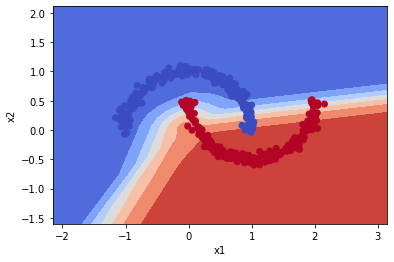

In [59]:
# Set min and max values for meshgrid
x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1

# Generate a grid of points with distance h between them
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the function value for the whole grid using previous params
L = len(params) // 2
X_mesh = np.c_[xx.ravel(), yy.ravel()].T
Z = forward_prop(X_mesh, params)['A' + str(L)]
Z = Z.reshape(xx.shape)

# Plot the contour and training examples
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
plt.ylabel('x2')
plt.xlabel('x1')
plt.scatter(X_test[0, :], X_test[1, :], c=np.squeeze(y_test), cmap=plt.cm.coolwarm)